In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [1]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [8]:
path = 'C:/Users/GCC/git'
trading_df = pd.read_csv(f"{path}/data/DL/매매내역_서울경기.csv")

## 힐스테이트 서초 젠드리스 결측
trading_df['법정동본번코드'][trading_df['아파트'] == '힐스테이트 서초 젠트리스'] = 557
trading_df['법정동부번코드'][trading_df['아파트'] == '힐스테이트 서초 젠트리스'] = 0

## 해제단지 제외
trading_df = trading_df[trading_df['해제여부'] != 'O']

trading_df['평형대코드'] = '5'
trading_df['평형대코드'][trading_df['전용면적'] < 136] = '4'
trading_df['평형대코드'][trading_df['전용면적'] < 85] = '3'
trading_df['평형대코드'][trading_df['전용면적'] < 60] = '2'
trading_df['평형대코드'][trading_df['전용면적'] < 48] = '1'

In [9]:
## 법정동코드 불러오기
dl_path = 'C:/Users/GCC/git/data/DL/'
bjd_cd_df = pd.read_csv(f'{dl_path}법정동코드 전체자료.txt', encoding='cp949', sep='\t', dtype=str)
bjd_cd_df['시군구코드'] = bjd_cd_df['법정동코드'].str.slice(0, 5)
bjd_cd_df['시도코드'] = bjd_cd_df['법정동코드'].str.slice(0, 2)
bjd_cd_df['위상구분'] = '읍면동'
bjd_cd_df['위상구분'][bjd_cd_df['법정동코드'].apply(lambda x: x[5:]) == '00000'] = '시군구'
bjd_cd_df['위상구분'][bjd_cd_df['법정동코드'].apply(lambda x: x[2:5]) == '000'] = '시도'

In [10]:
## 단지매핑정보를 불러와서 세대수와 식별자를 부여함
path = 'C:/Users/GCC/git'
danji_mapping_info = pd.read_csv(f"{path}/data/DL/단지매핑정보.csv", dtype='str')
danji_mapping_info = danji_mapping_info[['단지고유번호', 'PNU', '단지명_공시가격', '동수', '세대수', '사용승인일']].rename(columns={'단지명_공시가격':'아파트'})
## 모든 대장번호를 0으로 적용
danji_mapping_info['PNU'] = danji_mapping_info['PNU'].apply(lambda x:x[:10]+'0'+x[11:])
danji_mapping_info = danji_mapping_info.drop_duplicates(subset=['PNU', '아파트'])
danji_mapping_info[['동수', '세대수']] = danji_mapping_info[['동수', '세대수']].astype('int')

In [26]:
## 마스터 테이블
danji_pyeong_info = trading_df.sort_values(by=['년', '월', '일', ], ascending=False)[['일련번호', '전용면적', '평형대코드', '아파트', '건축년도', '등기일자',
            '도로명시군구코드', '도로명일련번호코드', '도로명지상지하코드', '도로명코드', '도로명', '도로명건물본번호코드', '도로명건물부번호코드',
            '법정동시군구코드', '법정동읍면동코드', '법정동지번코드','법정동본번코드', '법정동부번코드', '법정동', 
            '지번']].drop_duplicates(subset=['일련번호', '전용면적', '아파트']).copy()

danji_pyeong_info['법정동시군구코드'] = danji_pyeong_info['법정동시군구코드'].astype('str')
danji_pyeong_info['법정동읍면동코드'] = danji_pyeong_info['법정동읍면동코드'].astype('str')
danji_pyeong_info['법정동본번코드'] = danji_pyeong_info['법정동본번코드'].astype(str).str.replace('A', '')
danji_pyeong_info['법정동본번코드'] = (danji_pyeong_info['법정동본번코드'].astype('float').astype('int') + 10000).astype('str').apply(lambda x:x[1:])
danji_pyeong_info['법정동부번코드'] = (danji_pyeong_info['법정동부번코드'].astype('int') + 10000).astype('str').apply(lambda x:x[1:])

danji_pyeong_info['PNU'] = danji_pyeong_info['법정동시군구코드'] + danji_pyeong_info['법정동읍면동코드'] + '0' + danji_pyeong_info['법정동본번코드'] + danji_pyeong_info['법정동부번코드']
danji_pyeong_info[['법정동시군구코드', '법정동읍면동코드', 'PNU']] = danji_pyeong_info[['법정동시군구코드', '법정동읍면동코드', 'PNU']].astype('int64').astype('str')
danji_pyeong_info['법정동코드'] = danji_pyeong_info['법정동시군구코드'] + danji_pyeong_info['법정동읍면동코드']

In [27]:
danji_mst= danji_pyeong_info[['일련번호' , '아파트', '법정동시군구코드', '법정동코드', 'PNU', '건축년도']].drop_duplicates(subset=['일련번호'])
danji_mst['연식'] = 2024 - danji_mst['건축년도'] + 1

In [31]:
## 단지매핑정보와 결합해서 단지고유번호를 부여
temp = danji_mst.merge(danji_mapping_info).drop_duplicates('일련번호')
temp = pd.pivot_table(temp, index=['법정동시군구코드', '법정동코드'], values=['세대수', '연식'], aggfunc=['sum', 'mean']).reset_index()
temp['세대수'] = temp['sum']['세대수']
temp['연식'] = temp['mean']['연식']
temp = temp[['법정동시군구코드', '법정동코드', '세대수', '연식']]
temp.columns = ['법정동시군구코드', '법정동코드', '세대수', '연식']
tt = pd.pivot_table(danji_pyeong_info, index=['법정동시군구코드', '법정동코드'], values='전용면적', aggfunc='mean').reset_index()
temp = pd.merge(temp, bjd_cd_df[['법정동코드', '법정동명']], on = '법정동코드').merge(tt)
temp[['연식', '전용면적']] = temp[['연식', '전용면적']].astype('int')
temp = temp[temp['법정동시군구코드'] == '41610']
temp = temp[['법정동코드', '법정동명', '연식', '세대수', '전용면적']].reset_index(drop=True)

In [157]:
temp.to_csv("강남구읍면동특성.csv", index=False, encoding="utf-8-sig")

In [11]:
## 거래내역 원천 테이블
trading_trs = trading_df[['년', '월', '일', '일련번호', '평형대코드','전용면적', '동', '층', '거래금액']][trading_df['거래유형'] !='직거래'].copy()
trading_trs['거래금액'] = trading_trs['거래금액'].apply(lambda x: int(x.replace(',', '')))

,일련번호,법정동시군구코드,법정동읍면동코드,PNU,건축년도
93179,11200-19,11200,10700,1120010700003450000,1997
269386,11290-82,11290,13300,1129013300002390000,2005
354635,11320-21,11320,10500,1132010500000590000,1988
354647,11320-42,11320,10600,1132010600002710001,1986
354679,11320-98,11320,10700,1132010700003470000,1990
...,...,...,...,...,...
1045135,11680-484,11680,10400,1168010400001130006,1997
571654,11440-21,11440,10500,1144010500001490069,1970
986452,11650-216,11650,10700,1165010700000200001,1980
571643,11440-1151,11440,10500,1144010500004960007,1971


In [12]:
trading_trs

,년,월,일,일련번호,평형대코드,전용면적,동,층,거래금액
0,2006,2,6,11110-205,1,40.07,NaN,7,22555
1,2006,2,2,11110-16,4,90.13,NaN,8,24813
2,2006,2,10,11110-16,4,90.13,NaN,8,24813
3,2006,2,17,11110-17,4,108.89,NaN,9,30000
4,2006,2,5,11110-121,3,84.42,NaN,6,22000
...,...,...,...,...,...,...,...,...,...
1275275,2023,12,28,11740-2628,3,84.99,NaN,7,133500
1275276,2023,12,30,11740-170,3,84.97,NaN,4,75950
1275277,2023,12,20,11740-2852,3,84.53,NaN,9,87000
1275278,2023,12,23,11740-4743,2,49.82,402,6,65000


In [24]:
## 필요컬럼 전처리
trading_trs_v2 = pd.pivot_table(trading_trs, index=['년', '월', '일련번호', '평형대코드', '전용면적'], values='거래금액', aggfunc=np.mean).reset_index()
trading_trs_v2['기준년월'] = pd.to_datetime(trading_trs_v2['년'].astype('str') + '-' + trading_trs_v2['월'].astype('str'))
trading_trs_v2['단위매매거래금액'] = (trading_trs_v2['거래금액']/trading_trs_v2['전용면적'])
trading_trs_v2 = trading_trs_v2.merge(danji_mst[['일련번호', '법정동시군구코드', '법정동읍면동코드']].drop_duplicates().copy(), on='일련번호', how='left')

In [25]:
## 아우터 조인
_p1 = trading_trs_v2[['기준년월']].drop_duplicates()
_p1['dummy'] = 1
_p2 = trading_trs_v2[['일련번호', '평형대코드', '법정동시군구코드', '법정동읍면동코드']].drop_duplicates()
_p2['dummy'] = 1
trading_trs_v3 = pd.merge(_p1, _p2, on='dummy').drop('dummy', axis=1)

## 단위별 단위매매거래금액 집계
trading_trs_danji = pd.pivot_table(trading_trs_v2, index=['기준년월', '일련번호', '평형대코드'], values='단위매매거래금액', aggfunc=np.mean).reset_index()
trading_trs_bjd = pd.pivot_table(trading_trs_v2, index=['기준년월', '법정동시군구코드', '법정동읍면동코드', '평형대코드'],
                                 values='단위매매거래금액', aggfunc=np.mean).rename(columns={'단위매매거래금액':'읍면동평균매매거래금액'}).reset_index()
trading_trs_sgg = pd.pivot_table(trading_trs_v2, index=['기준년월', '법정동시군구코드', '평형대코드'],
                                 values='단위매매거래금액', aggfunc=np.mean).rename(columns={'단위매매거래금액':'시군구평균매매거래금액'}).reset_index()
trading_trs_v3 = trading_trs_v3.merge(trading_trs_danji, how='left').merge(trading_trs_bjd, how='left').merge(trading_trs_sgg, how='left')

## 단위별 대표값 교환비
ratio = trading_trs_v3.copy()
ratio['시군구교환비'] = ratio['단위매매거래금액']/ratio['시군구평균매매거래금액']
ratio['읍면동교환비'] = ratio['단위매매거래금액']/ratio['읍면동평균매매거래금액']
ratio = pd.pivot_table(ratio, index=['일련번호', '평형대코드', '법정동시군구코드', '법정동읍면동코드'],
                       values=['시군구교환비', '읍면동교환비'],
                       aggfunc=np.mean).reset_index()

trading_trs_v3 = pd.merge(trading_trs_v3, ratio, on=['일련번호', '평형대코드', '법정동시군구코드', '법정동읍면동코드'], how='left')
trading_trs_v3['보간읍면동매매거래금액'] = trading_trs_v3['읍면동평균매매거래금액'] * trading_trs_v3['읍면동교환비']
trading_trs_v3['보간시군구매매거래금액'] = trading_trs_v3['시군구평균매매거래금액'] * trading_trs_v3['시군구교환비']

trading_trs_v3['단위매매거래금액'][trading_trs_v3['단위매매거래금액'].isna()] = trading_trs_v3['읍면동평균매매거래금액'][trading_trs_v3['단위매매거래금액'].isna()]
trading_trs_v3['단위매매거래금액'][trading_trs_v3['단위매매거래금액'].isna()] = trading_trs_v3['시군구평균매매거래금액'][trading_trs_v3['단위매매거래금액'].isna()]

trading_trs_v3['단지평형대코드'] = trading_trs_v3['일련번호'] + '/' + trading_trs_v3['평형대코드']
trading_trs_v3 = pd.pivot_table(trading_trs_v3, index=['기준년월'], columns=['단지평형대코드'], values='단위매매거래금액', aggfunc=np.mean)
trading_trs_v3 = trading_trs_v3.interpolate(method='linear', axis=1, limit_direction='both')
trading_trs_v3 = trading_trs_v3.reset_index().melt(id_vars=['기준년월'], value_name='단위매매거래금액')

trading_trs_v3['일련번호'] = trading_trs_v3['단지평형대코드'].apply(lambda x: x.split('/')[0])
trading_trs_v3['평형대코드'] = trading_trs_v3['단지평형대코드'].apply(lambda x: x.split('/')[1])
trading_trs_v3 = trading_trs_v3.drop('단지평형대코드', axis=1)

In [80]:
danji_mst[['법정동시군구코드', '법정동읍면동코드', '법정동지번코드', '법정동본번코드', '법정동부번코드',]]

,법정동시군구코드,법정동읍면동코드,법정동지번코드,법정동본번코드,법정동부번코드
93387,11200,10700,1.0,345.0,0.0
269149,11290,13300,1.0,239.0,0.0
354846,11320,10500,1.0,59.0,0.0
354858,11320,10600,1.0,271.0,1.0
354891,11320,10700,1.0,347.0,0.0
...,...,...,...,...,...
985551,11650,10800,1.0,1310.0,0.0
840854,11560,11000,1.0,42.0,0.0
940460,11620,10100,1.0,24.0,14.0
817899,11545,10300,1.0,109.0,1.0


In [26]:
trading_trs_v4 = danji_mst[['일련번호', '아파트', '전용면적', '평형대코드']].merge(trading_trs_v3, how='left')

In [27]:
trading_trs_v4['보정매매거래금액'] = trading_trs_v4['전용면적'] * trading_trs_v4['단위매매거래금액']

In [56]:
trading_trs_v4[trading_trs_v4['아파트'] == '그라나다']

,일련번호,아파트,전용면적,평형대코드,기준년월,단위매매거래금액,보정매매거래금액
1903212,11680-511,그라나다,47.88,1,2006-01-01,357.088260,17097.385898
1903213,11680-511,그라나다,47.88,1,2006-02-01,387.168142,18537.610619
1903214,11680-511,그라나다,47.88,1,2006-03-01,398.899587,19099.312242
1903215,11680-511,그라나다,47.88,1,2006-04-01,429.169799,20548.649962
1903216,11680-511,그라나다,47.88,1,2006-05-01,747.394933,35785.269377
...,...,...,...,...,...,...,...
4232618,11680-511,그라나다,45.23,1,2023-09-01,2609.194001,118013.844669
4232619,11680-511,그라나다,45.23,1,2023-10-01,3557.179443,160891.226223
4232620,11680-511,그라나다,45.23,1,2023-11-01,1064.649243,48154.085282
4232621,11680-511,그라나다,45.23,1,2023-12-01,1055.555556,47742.777778


<Axes: xlabel='기준년월'>

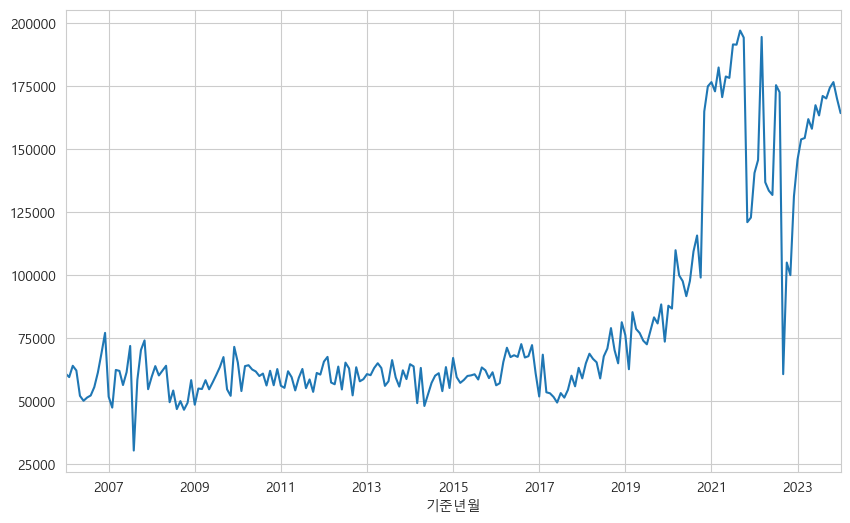

In [43]:
trading_trs_v4[(trading_trs_v4['일련번호'] == '11710-8865')&(trading_trs_v4['전용면적'] == 59.96)].sort_values(by='기준년월', ascending=True).set_index('기준년월')['보정매매거래금액'].plot()

In [45]:
trading_trs_v2[(trading_trs_v2['일련번호'] == '11710-8865')&(trading_trs_v2['전용면적'] == 59.96)]

,년,월,일련번호,평형대코드,전용면적,거래금액,기준년월,단위매매거래금액,법정동시군구코드,법정동읍면동코드
655802,2020,11,11710-8865,2,59.96,165000.000000,2020-11-01,2751.834556,11710,10700
660261,2020,12,11710-8865,2,59.96,175000.000000,2020-12-01,2918.612408,11710,10700
664063,2021,1,11710-8865,2,59.96,176666.666667,2021-01-01,2946.408717,11710,10700
666990,2021,2,11710-8865,2,59.96,173000.000000,2021-02-01,2885.256838,11710,10700
672573,2021,4,11710-8865,2,59.96,170714.285714,2021-04-01,2847.136186,11710,10700
675815,2021,5,11710-8865,2,59.96,177425.000000,2021-05-01,2959.056037,11710,10700
678659,2021,6,11710-8865,2,59.96,178333.333333,2021-06-01,2974.205026,11710,10700
681860,2021,7,11710-8865,2,59.96,186500.000000,2021-07-01,3110.406938,11710,10700
684869,2021,8,11710-8865,2,59.96,190833.333333,2021-08-01,3182.677340,11710,10700
687113,2021,9,11710-8865,2,59.96,197133.333333,2021-09-01,3287.747387,11710,10700


In [17]:
trading_trs_v2

,년,월,일련번호,평형대코드,전용면적,거래금액,기준년월,평당매매거래금액,법정동시군구코드,법정동읍면동코드
0,2006,1,11110-13,4,93.400,29500.000000,2006-01-01,1043.712527,11110,11700
1,2006,1,11110-131,1,47.630,10500.000000,2006-01-01,728.474701,11110,17500
2,2006,1,11110-16,2,57.180,15741.000000,2006-01-01,909.691055,11110,13300
3,2006,1,11110-16,3,78.230,21535.000000,2006-01-01,909.656238,11110,13300
4,2006,1,11110-16,3,84.260,23198.000000,2006-01-01,909.776774,11110,13300
...,...,...,...,...,...,...,...,...,...,...
724783,2024,1,11740-7,3,84.755,138000.000000,2024-01-01,5380.461330,11740,10100
724784,2024,1,11740-71,2,48.100,48000.000000,2024-01-01,3297.629938,11740,10600
724785,2024,1,11740-79,3,84.360,101000.000000,2024-01-01,3956.312233,11740,10600
724786,2024,1,11740-90,2,59.690,91000.000000,2024-01-01,5037.853912,11740,10700


In [ ]:
## 전용면적 * 평당매매거래금액 => 라인, 분석용
## 원천거래금액 => 포인트용

In [402]:
trading_trs

,년,월,일,일련번호,평형대코드,전용면적,동,층,거래금액
0,2006,2,6,11110-205,1,40.07,NaN,7,22555
1,2006,2,2,11110-16,4,90.13,NaN,8,24813
2,2006,2,10,11110-16,4,90.13,NaN,8,24813
3,2006,2,17,11110-17,4,108.89,NaN,9,30000
4,2006,2,5,11110-121,3,84.42,NaN,6,22000
...,...,...,...,...,...,...,...,...,...
1275275,2023,12,28,11740-2628,3,84.99,NaN,7,133500
1275276,2023,12,30,11740-170,3,84.97,NaN,4,75950
1275277,2023,12,20,11740-2852,3,84.53,NaN,9,87000
1275278,2023,12,23,11740-4743,2,49.82,402,6,65000


,기준년월,단지평형대코드,평당매매거래금액
0,2006-01-01,11110-10-1,1238.641058
1,2006-02-01,11110-10-1,1365.921604
2,2006-03-01,11110-10-1,1606.354167
3,2006-04-01,11110-10-1,836.051758
4,2006-05-01,11110-10-1,1403.783047
...,...,...,...
3441398,2023-09-01,11740-99-4,4678.176841
3441399,2023-10-01,11740-99-4,4421.327268
3441400,2023-11-01,11740-99-4,4527.092846
3441401,2023-12-01,11740-99-4,2311.503450


In [332]:
trading_trs_v3[(trading_trs_v3['일련번호'] == '11440-223')&(trading_trs_v3['평형대코드'] == '5')].dropna()

,기준년월,일련번호,평형대코드,법정동시군구코드,법정동읍면동코드,평당매매거래금액,읍면동평균매매거래금액,시군구평균매매거래금액,시군구교환비,읍면동교환비
1535897,2014-01-01,11440-223,5,11440,10200,38.812544,1151.780329,2058.964201,0.018851,0.033698


In [356]:
trading_df[trading_df['일련번호'] == '11440-223'][['년', '거래금액']]

,년,거래금액
584901,2014,"2,000"
612176,2022,"35,000"


In [337]:
trading_df

,거래금액,거래유형,건축년도,년,도로명,도로명건물본번호코드,도로명건물부번호코드,도로명시군구코드,도로명일련번호코드,도로명지상지하코드,...,월,일,일련번호,전용면적,중개사소재지,지번,지역코드,층,해제사유발생일,해제여부
0,"22,555",NaN,2005,2006,율곡로2길,7.0,0.0,11110.0,1.0,0.0,...,2,6,11110-205,40.07,NaN,85,11110,7,NaN,NaN
1,"24,813",NaN,1998,2006,삼일대로32길,36.0,0.0,11110.0,2.0,0.0,...,2,2,11110-16,90.13,NaN,30-6,11110,8,NaN,NaN
2,"24,813",NaN,1998,2006,삼일대로32길,36.0,0.0,11110.0,2.0,0.0,...,2,10,11110-16,90.13,NaN,30-6,11110,8,NaN,NaN
3,"30,000",NaN,1968,2006,삼일대로,428.0,0.0,11110.0,5.0,0.0,...,2,17,11110-17,108.89,NaN,288,11110,9,NaN,NaN
4,"22,000",NaN,2004,2006,율곡로19길,41.0,6.0,11110.0,1.0,0.0,...,2,5,11110-121,84.42,NaN,9-1,11110,6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275275,"133,500",중개거래,2007,2023,올림픽로89길,57.0,0.0,11740.0,1.0,0.0,...,12,28,11740-2628,84.99,서울 강동구,568,11740,7,NaN,NaN
1275276,"75,950",중개거래,2000,2023,구천면로,278.0,0.0,11740.0,4.0,0.0,...,12,30,11740-170,84.97,서울 강동구,217-132,11740,4,NaN,NaN
1275277,"87,000",중개거래,2009,2023,아리수로93길,40.0,0.0,11740.0,1.0,0.0,...,12,20,11740-2852,84.53,서울 강동구,674,11740,9,NaN,NaN
1275278,"65,000",중개거래,2020,2023,아리수로93가길,110.0,0.0,11740.0,0.0,NaN,...,12,23,11740-4743,49.82,서울 강동구,114,11740,6,NaN,NaN


In [176]:
ratio['읍면동평균매매거래금액']/ratio['평당매매거래금액']

In [197]:
pd.merge(trading_trs_v3_sgg, trading_trs_v3_bjd, on=['기준년월', '법정동시군구코드','평형대코드'])

,기준년월,법정동시군구코드,평형대코드,시군구평균매매거래금액,법정동읍면동코드,읍면동평균매매거래금액
0,2006-01-01,11110,1,1111.099468,17100,1493.724236
1,2006-01-01,11110,1,1111.099468,17500,728.474701
2,2006-01-01,11110,2,943.098970,13300,909.691055
3,2006-01-01,11110,2,943.098970,17400,989.235603
4,2006-01-01,11110,2,943.098970,18300,966.712638
...,...,...,...,...,...,...
148830,2024-01-01,11740,4,3991.318470,10200,5267.476733
148831,2024-01-01,11740,4,3991.318470,10600,3403.829947
148832,2024-01-01,11740,4,3991.318470,10700,4501.274501
148833,2024-01-01,11740,4,3991.318470,10800,3573.759586


In [181]:
trading_trs_v3_sgg

,기준년월,법정동시군구코드,평형대코드,평당매매거래금액
0,2006-01-01,11110,1,1111.099468
1,2006-01-01,11110,2,943.098970
2,2006-01-01,11110,3,1104.981718
3,2006-01-01,11110,4,1157.247371
4,2006-01-01,11140,1,611.372946
...,...,...,...,...
25908,2024-01-01,11710,5,5765.079753
25909,2024-01-01,11740,1,2817.169894
25910,2024-01-01,11740,2,5258.827560
25911,2024-01-01,11740,3,4027.182915


In [182]:
trading_trs_v3_bjd

,기준년월,법정동읍면동코드,평형대코드,평당매매거래금액
0,2006-01-01,10100,1,1126.435756
1,2006-01-01,10100,2,1280.691139
2,2006-01-01,10100,3,1443.550701
3,2006-01-01,10100,4,1743.978447
4,2006-01-01,10100,5,2078.523279
...,...,...,...,...
39167,2024-01-01,17500,3,3818.675230
39168,2024-01-01,17700,3,7790.334045
39169,2024-01-01,17900,2,8612.556742
39170,2024-01-01,17900,3,7595.575694


In [179]:
trading_trs_v3

,기준년월,일련번호,평형대코드,평당매매거래금액,법정동시군구코드,법정동읍면동코드
0,2006-01-01,11110-13,4,1043.712527,11110,11700
1,2006-01-01,11110-131,1,728.474701,11110,17500
2,2006-01-01,11110-16,2,909.691055,11110,13300
3,2006-01-01,11110-16,3,909.716506,11110,13300
4,2006-01-01,11110-26,1,1493.724236,11110,17100
...,...,...,...,...,...,...
600579,2024-01-01,11740-7,3,5506.987058,11740,10100
600580,2024-01-01,11740-71,2,3297.629938,11740,10600
600581,2024-01-01,11740-79,3,3956.312233,11740,10600
600582,2024-01-01,11740-90,2,5037.853912,11740,10700


,일련번호,법정동시군구코드,법정동읍면동코드
93179,11200-19,11200,10700
269386,11290-82,11290,13300
354635,11320-21,11320,10500
354647,11320-42,11320,10600
354679,11320-98,11320,10700
...,...,...,...
982462,11650-29,11650,10800
843668,11560-26,11560,11000
940290,11620-3965,11620,10100
817427,11545-38,11545,10300


In [147]:
trading_trs_v3

일련번호       11110-10             11110-100    11110-101    11110-102  \
평형대코드             1           2         2            5            1   
기준년월                                                                  
2006-01-01      NaN         NaN       NaN          NaN          NaN   
2006-02-01      NaN         NaN       NaN          NaN          NaN   
2006-03-01      NaN         NaN       NaN  1033.772254          NaN   
2006-04-01      NaN         NaN       NaN          NaN          NaN   
2006-05-01      NaN  1160.66642       NaN          NaN  1048.597770   
...             ...         ...       ...          ...          ...   
2023-09-01      NaN         NaN       NaN          NaN          NaN   
2023-10-01      NaN         NaN       NaN          NaN  2729.326497   
2023-11-01      NaN         NaN       NaN          NaN  2798.622427   
2023-12-01      NaN         NaN       NaN          NaN          NaN   
2024-01-01      NaN         NaN       NaN          NaN          NaN   

일련번호                    11110-105            11110-107  ... 11740-96      \
평형대코드                 2         1   2   3            4  ...        2   3   
기준년월                                                    ...                
2006-01-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   
2006-02-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   
2006-03-01          NaN       NaN NaN NaN  2197.973403  ...      NaN NaN   
2006-04-01  1021.168109       NaN NaN NaN  1130.478462  ...      NaN NaN   
2006-05-01          NaN       NaN NaN NaN  2244.613892  ...      NaN NaN   
...                 ...       ...  ..  ..          ...  ...      ...  ..   
2023-09-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   
2023-10-01  2961.387515       NaN NaN NaN          NaN  ...      NaN NaN   
2023-11-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   
2023-12-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   
2024-01-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   

일련번호       11740-969              11740-97     11740-98              \
평형대코드              2            3        3   5        2           3   
기준년월                                                                  
2006-01-01       NaN          NaN      NaN NaN      NaN  990.320067   
2006-02-01       NaN          NaN      NaN NaN      NaN         NaN   
2006-03-01       NaN   945.895369      NaN NaN      NaN         NaN   
2006-04-01       NaN          NaN      NaN NaN      NaN         NaN   
2006-05-01       NaN          NaN      NaN NaN      NaN         NaN   
...              ...          ...      ...  ..      ...         ...   
2023-09-01       NaN          NaN      NaN NaN      NaN         NaN   
2023-10-01       NaN          NaN      NaN NaN      NaN         NaN   
2023-11-01       NaN  3283.059611      NaN NaN      NaN         NaN   
2023-12-01       NaN          NaN      NaN NaN      NaN         NaN   
2024-01-01       NaN          NaN      NaN NaN      NaN         NaN   

일련번호           11740-99              
평형대코드                 2           4  
기준년월                                 
2006-01-01   899.410282         NaN  
2006-02-01   893.858367         NaN  
2006-03-01   975.749118         NaN  
2006-04-01   888.306452         NaN  
2006-05-01          NaN         NaN  
...                 ...         ...  
2023-09-01          NaN         NaN  
2023-10-01          NaN         NaN  
2023-11-01  3109.072581         NaN  
2023-12-01          NaN  2311.50345  
2024-01-01          NaN         NaN  

[217 rows x 15859 columns]

일련번호       11110-10             11110-100    11110-101    11110-102  \
평형대코드             1           2         2            5            1   
기준년월                                                                  
2006-01-01      NaN         NaN       NaN          NaN          NaN   
2006-02-01      NaN         NaN       NaN          NaN          NaN   
2006-03-01      NaN         NaN       NaN  1033.772254          NaN   
2006-04-01      NaN         NaN       NaN          NaN          NaN   
2006-05-01      NaN  1160.66642       NaN          NaN  1048.597770   
...             ...         ...       ...          ...          ...   
2023-09-01      NaN         NaN       NaN          NaN          NaN   
2023-10-01      NaN         NaN       NaN          NaN  2729.326497   
2023-11-01      NaN         NaN       NaN          NaN  2798.622427   
2023-12-01      NaN         NaN       NaN          NaN          NaN   
2024-01-01      NaN         NaN       NaN          NaN          NaN   

일련번호                    11110-105            11110-107  ... 11740-96      \
평형대코드                 2         1   2   3            4  ...        2   3   
기준년월                                                    ...                
2006-01-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   
2006-02-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   
2006-03-01          NaN       NaN NaN NaN  2197.973403  ...      NaN NaN   
2006-04-01  1021.168109       NaN NaN NaN  1130.478462  ...      NaN NaN   
2006-05-01          NaN       NaN NaN NaN  2244.613892  ...      NaN NaN   
...                 ...       ...  ..  ..          ...  ...      ...  ..   
2023-09-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   
2023-10-01  2961.387515       NaN NaN NaN          NaN  ...      NaN NaN   
2023-11-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   
2023-12-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   
2024-01-01          NaN       NaN NaN NaN          NaN  ...      NaN NaN   

일련번호       11740-969              11740-97     11740-98              \
평형대코드              2            3        3   5        2           3   
기준년월                                                                  
2006-01-01       NaN          NaN      NaN NaN      NaN  990.320067   
2006-02-01       NaN          NaN      NaN NaN      NaN         NaN   
2006-03-01       NaN   945.895369      NaN NaN      NaN         NaN   
2006-04-01       NaN          NaN      NaN NaN      NaN         NaN   
2006-05-01       NaN          NaN      NaN NaN      NaN         NaN   
...              ...          ...      ...  ..      ...         ...   
2023-09-01       NaN          NaN      NaN NaN      NaN         NaN   
2023-10-01       NaN          NaN      NaN NaN      NaN         NaN   
2023-11-01       NaN  3283.059611      NaN NaN      NaN         NaN   
2023-12-01       NaN          NaN      NaN NaN      NaN         NaN   
2024-01-01       NaN          NaN      NaN NaN      NaN         NaN   

일련번호           11740-99              
평형대코드                 2           4  
기준년월                                 
2006-01-01   899.410282         NaN  
2006-02-01   893.858367         NaN  
2006-03-01   975.749118         NaN  
2006-04-01   888.306452         NaN  
2006-05-01          NaN         NaN  
...                 ...         ...  
2023-09-01          NaN         NaN  
2023-10-01          NaN         NaN  
2023-11-01  3109.072581         NaN  
2023-12-01          NaN  2311.50345  
2024-01-01          NaN         NaN  

[217 rows x 15859 columns]

In [43]:
tt = pd.merge(temp, danji_mst[['단지명']], left_on='아파트', right_on='단지명', how='left')

In [46]:
tt[tt['단지명'].isna()]

,일련번호,아파트,법정동,도로명,단지명
1,11110-16,운현신화타워,익선동,삼일대로32길,NaN
2,11110-17,낙원,낙원동,삼일대로,NaN
3,11110-121,송림아마레스아파트,이화동,율곡로19길,NaN
4,11110-26,명륜동주상복합아남아파트,명륜2가,혜화로3길,NaN
5,11110-25,아남1,명륜2가,창경궁로,NaN
...,...,...,...,...,...
9329,11740-4804,강동리버스트8단지,강일동,아리수로93나길,NaN
9330,11740-4648,둔촌현대수린나아파트,둔촌동,동남로49길,NaN
9332,11740-4951,고덕아르테스미소지움,상일동,동남로,NaN
9333,11740-5039,거산유팰리스2차,길동,천호대로177길,NaN
